In [25]:
!pip install -q supervision jupyter_bbox_widget

In [26]:
import os
HOME = os.getcwd()
print(HOME)

/content/segment-anything-2


In [27]:
%cd {HOME}
!git clone https://github.com/IDEA-Research/GroundingDINO.git

/content/segment-anything-2
Cloning into 'GroundingDINO'...
remote: Enumerating objects: 463, done.
remote: Total 463 (delta 0), reused 0 (delta 0), pack-reused 463 (from 1)
Receiving objects: 100% (463/463), 12.91 MiB | 32.00 MiB/s, done.
Resolving deltas: 100% (220/220), done.


In [28]:
%cd /content/GroundingDINO/groundingdino/models/GroundingDINO/csrc/MsDeformAttn
!sed -i 's/value.type()/value.scalar_type()/g' ms_deform_attn_cuda.cu
!sed -i 's/value.scalar_type().is_cuda()/value.is_cuda()/g' ms_deform_attn_cuda.cu

/content/GroundingDINO/groundingdino/models/GroundingDINO/csrc/MsDeformAttn


In [29]:
%cd {HOME}/GroundingDINO
!pip install -q -e .
!pip install -q roboflow

/content/segment-anything-2/GroundingDINO
  Preparing metadata (setup.py) ... done
    error: subprocess-exited-with-error
    
    × python setup.py develop did not run successfully.
    │ exit code: 1
    ╰─> See above for output.
    
    note: This error originates from a subprocess, and is likely not a problem with pip.
error: subprocess-exited-with-error

× python setup.py develop did not run successfully.
│ exit code: 1
╰─> See above for output.

note: This error originates from a subprocess, and is likely not a problem with pip.


In [30]:
import os

CONFIG_PATH = os.path.join(HOME, "GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py")
print(CONFIG_PATH, "; exist:", os.path.isfile(CONFIG_PATH))

/content/segment-anything-2/GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py ; exist: True


In [31]:
%cd {HOME}
!mkdir {HOME}/weights
%cd {HOME}/weights

!wget -q https://github.com/IDEA-Research/GroundingDINO/releases/download/v0.1.0-alpha/groundingdino_swint_ogc.pth

/content/segment-anything-2
/content/segment-anything-2/weights


In [32]:
import os

WEIGHTS_NAME = "groundingdino_swint_ogc.pth"
WEIGHTS_PATH = os.path.join(HOME, "weights", WEIGHTS_NAME)
print(WEIGHTS_PATH, "; exist:", os.path.isfile(WEIGHTS_PATH))

/content/segment-anything-2/weights/groundingdino_swint_ogc.pth ; exist: True


In [33]:
%cd {HOME}/GroundingDINO

from groundingdino.util.inference import load_model, load_image, predict, annotate

model = load_model(CONFIG_PATH, WEIGHTS_PATH)

/content/segment-anything-2/GroundingDINO
final text_encoder_type: bert-base-uncased


In [34]:
!mkdir -p {HOME}/checkpoints
# !wget -q https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_tiny.pt -P {HOME}/checkpoints
# !wget -q https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_small.pt -P {HOME}/checkpoints
# !wget -q https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_base_plus.pt -P {HOME}/checkpoints
!wget -q https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_large.pt -P {HOME}/checkpoints

In [35]:
%cd ..

/content/segment-anything-2


In [36]:
!git clone https://github.com/facebookresearch/segment-anything-2.git
%cd {HOME}/segment-anything-2
!pip install -e . -q

Cloning into 'segment-anything-2'...
remote: Enumerating objects: 1070, done.
remote: Total 1070 (delta 0), reused 0 (delta 0), pack-reused 1070 (from 1)
Receiving objects: 100% (1070/1070), 128.11 MiB | 36.88 MiB/s, done.
Resolving deltas: 100% (381/381), done.
/content/segment-anything-2/segment-anything-2
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for SAM-2 (pyproject.toml) ... done


In [37]:
from google.colab import files

# --- Upload image ---
uploaded = files.upload()
image_path = list(uploaded.keys())[0]   # take the first uploaded file

Saving images.jpeg to images.jpeg


In [38]:
TEXT_PROMPT = input("Enter your text prompt (e.g., 'a cat', 'a person', 'a car'): ")

Enter your text prompt (e.g., 'a cat', 'a person', 'a car'): players


In [39]:
import torch
import base64
import matplotlib.pyplot as plt
import numpy as np
import supervision as sv
import cv2
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor
from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator

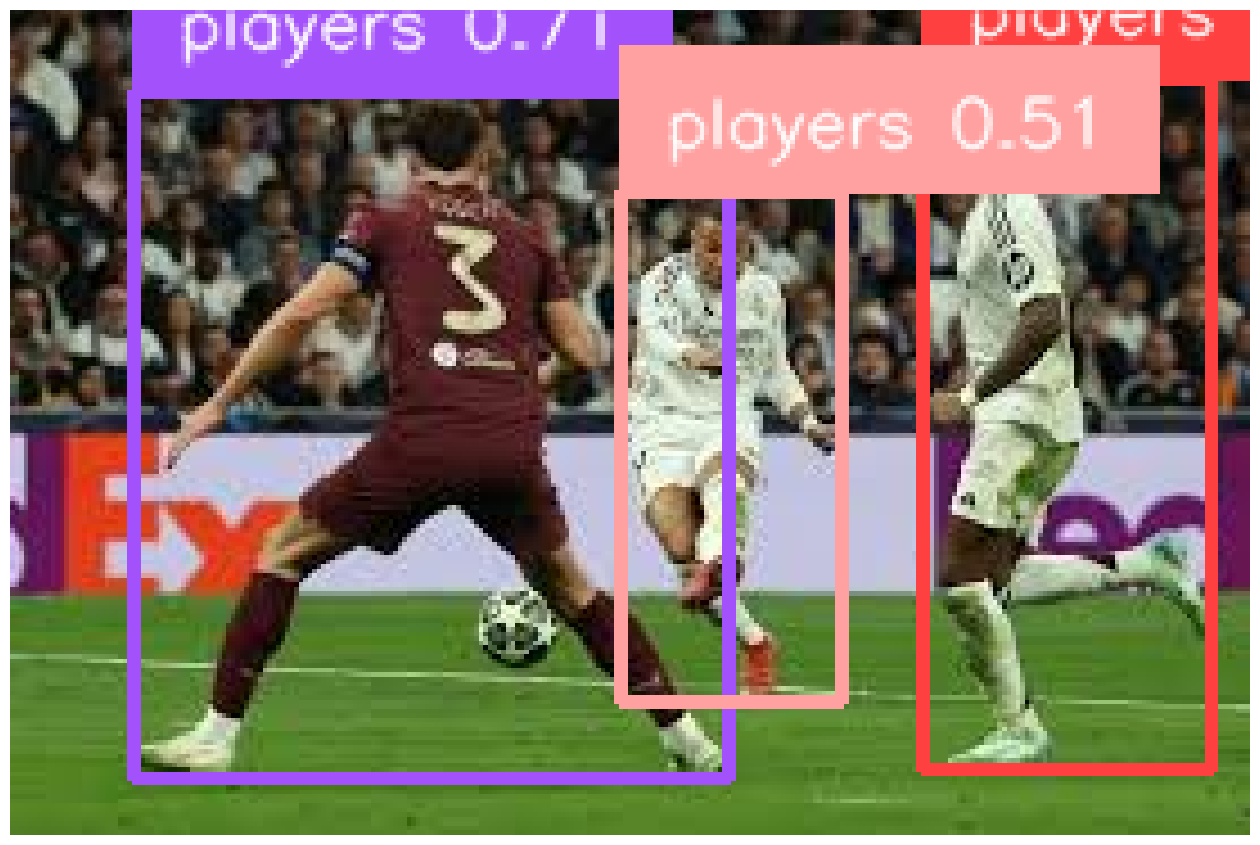

In [40]:
BOX_TRESHOLD = 0.35
TEXT_TRESHOLD = 0.25

image_source, image = load_image(image_path)


boxes, logits, phrases = predict(
    model=model,
    image=image,
    caption=TEXT_PROMPT,
    box_threshold=BOX_TRESHOLD,
    text_threshold=TEXT_TRESHOLD
)

annotated_frame = annotate(image_source=image_source, boxes=boxes, logits=logits, phrases=phrases)

%matplotlib inline
sv.plot_image(annotated_frame, (16, 16))

In [41]:
print(boxes)
print(logits)
print(phrases)

tensor([[0.3408, 0.5169, 0.4808, 0.8343],
        [0.8524, 0.5011, 0.2331, 0.8381],
        [0.5818, 0.5297, 0.1803, 0.6143]])
tensor([0.7103, 0.6112, 0.5055])
['players', 'players', 'players']


In [42]:
if torch.cuda.get_device_properties(0).major >= 8:
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True

In [43]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
CHECKPOINT = f"{HOME}/checkpoints/sam2_hiera_large.pt"
CONFIG = "sam2_hiera_l.yaml"

sam2_model = build_sam2(CONFIG, CHECKPOINT, device=DEVICE, apply_postprocessing=False)
sam2_model = sam2_model.to(DEVICE)
predictor = SAM2ImagePredictor(sam2_model)
mask_generator = SAM2AutomaticMaskGenerator(sam2_model)

In [44]:
image_bgr = cv2.imread(image_path)
H,W,_ = image_bgr.shape
print(image_bgr.shape)

(183, 275, 3)


In [45]:
xyxy_boxes = torch.zeros_like(boxes)
for i in range(boxes.shape[0]):
    x_c, y_c, w, h = boxes[i]
    x_c *= W
    y_c *= H
    w *= W
    h *= H
    x1 = x_c - w / 2
    y1 = y_c - h / 2
    x2 = x_c + w / 2
    y2 = y_c + h / 2

    xyxy_boxes[i] = torch.tensor([x1, y1, x2, y2])

In [46]:
print(xyxy_boxes)

tensor([[ 27.6182,  18.2560, 159.8479, 170.9415],
        [202.3689,  15.0273, 266.4707, 168.3927],
        [135.2158,  40.7360, 184.7989, 153.1453]])


In [47]:
predictor.set_image(image_source)

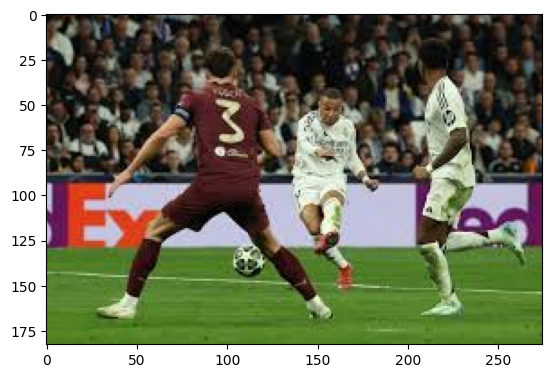

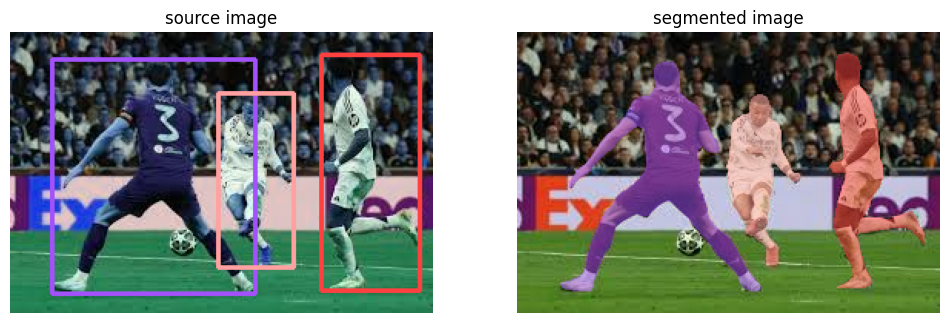

In [48]:
masks, scores, logits = predictor.predict(
    box=xyxy_boxes,
    multimask_output=False
)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(image_rgb)
boxes_pixel = xyxy_boxes.cpu().numpy().astype(int)
if masks.ndim == 4 and masks.shape[1] == 1:
    masks_fixed = np.squeeze(masks, axis=1)
else:
    masks_fixed = masks  # already in correct shape

box_annotator = sv.BoxAnnotator(color_lookup=sv.ColorLookup.INDEX)
mask_annotator = sv.MaskAnnotator(color_lookup=sv.ColorLookup.INDEX)
detections = sv.Detections(
    xyxy=boxes_pixel,
    mask=masks_fixed.astype(bool)
)
annotated_image = box_annotator.annotate(scene=image_source.copy(), detections=detections)
segmented_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)
sv.plot_images_grid(
    images=[annotated_image , segmented_image],
    grid_size=(1, 2),
    titles=['source image', 'segmented image']
)